# Benchmarking Object Storage with Cloudbutton

# Step by Step instructions

Let's setup all the necessary libraries:

In [19]:
%pylab inline
import numpy as np
import time
import os_benchmark
import pandas as pd
from six.moves import cPickle as pickle
import seaborn as sns
sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


**IMPORTANT** - We need to update the STORAGE_BACKEND and the CONTAINER variable with the Object Storage container that has been created for this experiment.

In [20]:
STORAGE_BACKEND = 'aliyun_oss'

In [21]:
BUCKET = 'galleda-d-aigua'

## Step by Step instructions

_**IMPORTANT** - This lab will write and read many files (200MB) from your bucket - make sure to clean out the bucket after the lab to avoid unnecessary cost._

We are going to benchmark a COS bucket by writing a large amount of data to a container, and then reading that data back. We are using the BUCKET variable, which is the bucket that was created. We will run 100 functions in parallel (_your account might have a soft limit of less parallel executions, if you encounter an error we suggest to change the `--number` parameter to a smaller value - also feel free to try with higher amount of workers to see the performance boost of parallel execution_ )

All of the actual benchmark code is in a stand-alone python file, which you can call as follows. It places the output in `write.pickle`. If you are interested in the details you can inspect the [os_benchmark.py](os_benchmark.py) file. Here is the relevant code snippet that invokes the distirbuten PyWren functions.


In [22]:
!python3 os_benchmark.py write --mb_per_file=200 --bucket_name={BUCKET} --number=100 --outfile={STORAGE_BACKEND}/write.pickle --key_prefix=benchmark

PyWren v1.5.1 init for Aliyun Function Compute
ExecutorID 7af68b/0 | JobID M000 - Selected Runtime: default - 1024MB 
ExecutorID 7af68b/0 | JobID M000 - Uploading function and data - Total: 10.2KiB
ExecutorID 7af68b/0 | JobID M000 - Starting function invocation: write_object()  - Total: 100 activations
ExecutorID 7af68b/0 - Getting results...

  100%|██████████████████████████████████████████████████████████████| 100/100  

ExecutorID 7af68b/0 - Cleaning temporary data


We then run the read test

In [23]:
!python3 os_benchmark.py read --key_file={STORAGE_BACKEND}/write.pickle --outfile={STORAGE_BACKEND}/read.pickle

PyWren v1.5.1 init for Aliyun Function Compute
ExecutorID 949bee/0 | JobID M000 - Selected Runtime: default - 1024MB 
ExecutorID 949bee/0 | JobID M000 - Uploading function and data - Total: 7.9KiB
ExecutorID 949bee/0 | JobID M000 - Starting function invocation: read_object()  - Total: 100 activations
ExecutorID 949bee/0 - Getting results...

  100%|██████████████████████████████████████████████████████████████| 100/100  

ExecutorID 949bee/0 - Cleaning temporary data


Now let's plot the results and see what's the distribution of read and write rates to IBM COS from our 200 IBM Cloud function executions:

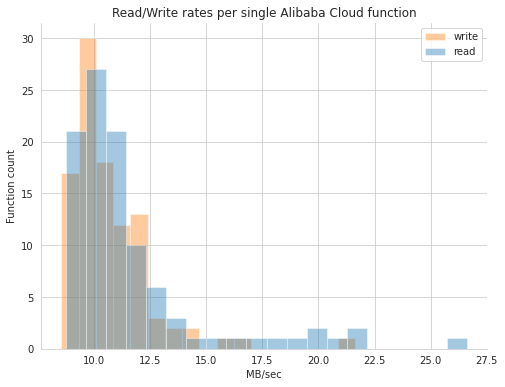

In [24]:
current_palette = sns.color_palette()
read_color = current_palette[0]
write_color = current_palette[1]

write_data = pickle.load(open(STORAGE_BACKEND+"/write.pickle", 'rb'))
write = os_benchmark.compute_times_rates(write_data['results'])

read_data = pickle.load(open(STORAGE_BACKEND+"/read.pickle", 'rb'))
read_time_results = [r[:3] for r in read_data['results'] if r is not None]
read  = os_benchmark.compute_times_rates(read_time_results)

fig = pylab.figure(figsize=(8, 6))
sns.distplot(write['rate'], label='write', color=write_color, kde=False)
sns.distplot(read['rate'], label='read', color=read_color, kde=False)

pylab.legend()
pylab.xlabel("MB/sec")
pylab.ylabel("Function count")
pylab.grid(True)
pylab.title("Read/Write rates per single Alibaba Cloud function")
sns.despine()
fig.savefig(STORAGE_BACKEND+"/rates.png")


We can investigate when jobs start and how long they run. Each horizontal line is a job, and then plotted on top is the aggregate number of jobs running at that moment. 

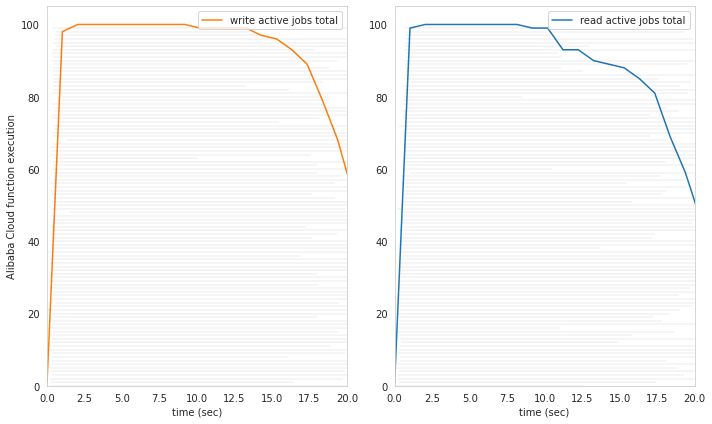

In [25]:
from matplotlib.collections import LineCollection
fig = pylab.figure(figsize=(10, 6))

for plot_i, (datum, l, c) in enumerate([(write, 'write', write_color), 
                                        (read, 'read', read_color)
                                       ]):
    ax = fig.add_subplot(1, 2, 1 + plot_i)

    N = len(datum['start_time'])
    line_segments = LineCollection([[[datum['start_time'][i], i], 
                                     [datum['end_time'][i], i]] for i in range(N)],
                                   linestyles='solid', color='k', alpha=0.4, linewidth=0.2)
    #line_segments.set_array(x)

    ax.add_collection(line_segments)

    ax.plot(os_benchmark.runtime_bins, datum['runtime_jobs_hist'].sum(axis=0), 
            c=c, label=l+' active jobs total', 
           zorder=-1)

    ax.set_xlim(0, 20)
    ax.set_ylim(0, len(datum['start_time'])*1.05)
    ax.set_xlabel("time (sec)")
    if plot_i == 0:
        ax.set_ylabel("Alibaba Cloud function execution")
    ax.grid(False)
    ax.legend(loc='upper right')
fig.tight_layout()
fig.savefig(STORAGE_BACKEND+"/concurrency.png")

Lastly let's plot all the values in aggregate over time:

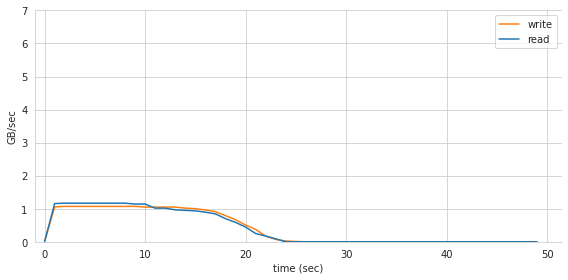

In [26]:
fig = pylab.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1)
for d, l, c in [(write, 'write', write_color), 
                (read, 'read', read_color)
               ]:
    ax.plot(d['runtime_rate_hist'].sum(axis=0)/1000, label=l, c=c)
ax.set_xlabel('time (sec)')
ax.set_ylabel("GB/sec")
ax.set_xlim(-1)
ax.set_ylim(0,7)
pylab.legend()
pylab.grid(True)
sns.despine()
fig.tight_layout()
fig.savefig(STORAGE_BACKEND+"/aggregate_bandwidth.png")

Please note that the performance will increase with the amount of workers (parallel IBM Cloud function executions) you will use.